In [1]:
import os
import numpy as np
from pandas import read_csv, concat
from tqdm import tqdm

## Section 1: Primary Analysis

#### 1.1 Load and prepare data

In [2]:
## Load behavioral correlates.
data = read_csv(os.path.join('data','correlates.csv'))

## Load total scores.
scores = read_csv(os.path.join('data','scores.csv'))

## Load rejection metrics.
metrics = read_csv(os.path.join('data','metrics.csv'))

## Merge DataFrames.
data = data.merge(scores).merge(metrics[['platform','subject','infreq']])

## Load Stan summary.
df = read_csv(os.path.join('stan_results','rstd_summary.tsv'), sep='\t', index_col='name')
df = df.T.filter(regex='theta').T

## Identify problematic participants.
sub = df.T.filter(regex='theta').T.query('R_hat > 1')
sub = np.unique([int(s.replace(']','').split(',')[-1]) - 1 for s in sub.index])

## Mask participants with ill-fitting models.
mask_ix = metrics.subject.sort_values().values[sub]
data.loc[data.subject.isin(mask_ix),['beta','eta_p','eta_n']] = np.nan

#### 1.2 Percentile Bootstrap Analysis

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define queries.
queries = [
    'infreq > -1',
    'accuracy > 0.411',
    'infreq == 0',
    'accuracy > 0.411 and infreq == 0'
]

## Define variables of interest.
rows = ['accuracy','points','ws','ls','perseveration','beta','eta_p','eta_n','kappa']
cols = ['7u','7d','gad7','bis','bas','shaps','pswq']

## Define number of bootstraps.
n_iter = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Percentile bootstrap. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space.
corr = np.zeros(( len(queries), len(rows), len(cols) ))
pval = np.zeros_like(corr)

## Main loop.
for i, query in enumerate(queries):
    
    ## Copy DataFrame.
    df = data.query(query)[rows+cols].copy()
    indices = np.arange(df.shape[0])
    
    ## Compute observed correlations.
    corr[i] = df.corr(method='spearman').loc[rows,cols].values
    
    ## Preallocate space.
    null = np.zeros((n_iter, len(rows), len(cols)))
    
    ## Iteratively compute null distribution.
    for j in tqdm(range(n_iter)):
        
        ## Sample bootstrap sequence.
        ix = np.random.choice(indices, indices.size, replace=True)

        ## Compute bootstrap correlations.
        null[j] = df.iloc[ix].corr(method='spearman').loc[rows,cols].values
        
    ## Compute p-values.
    pval[i] = np.where(np.sign(corr[i]) > 0, null < 0, null > 0).mean(axis=0)

100%|██████████| 5000/5000 [00:43<00:00, 113.67it/s]


## Section 2: Secondary Analyses

In [4]:
from scipy.stats import spearmanr, ttest_rel

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define sample size.
n_samp = (data.infreq == 0).sum()

## Define number of bootstraps.
n_iter = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Percentile bootstrap. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Define convenience function.
f = lambda x,y: spearmanr(x,y)[-1]

## Preallocate space.
null_pval = np.zeros(( n_iter, len(rows), len(cols) ))

## Main loop.
for i in tqdm(range(n_iter)):
    
    ## Copy DataFrame.
    df = data.iloc[np.random.choice(np.arange(data.shape[0]), n_samp)].copy()
    
    ## Compute observed correlations.
    null_pval[i] = df.corr(method=f).loc[rows,cols].values
    
## Compute false positive rate.
fpr = (null_pval < 0.05).mean(axis=0)

## Compute simple matching correlation.
smc_1 = np.apply_over_axes(np.sum, (pval[0] < 0.05) == (null < 0.05), [1,2]).squeeze() / fpr.size
smc_3 = np.apply_over_axes(np.sum, (pval[2] < 0.05) == (null < 0.05), [1,2]).squeeze() / fpr.size
smc_t, _ = ttest_rel(smc_1, smc_3)
smc_p = (smc_1 < smc_3).mean()
print('t = %0.2f, p < %0.3f' %(smc_t, smc_p))

100%|██████████| 5000/5000 [10:13<00:00,  8.15it/s]

t = 262.49, p < 0.001


## Section 3: Plotting

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set_theme('notebook', style='white', font='sans-serif', font_scale=1.33)
%matplotlib inline

#### 3.1 Main Figure

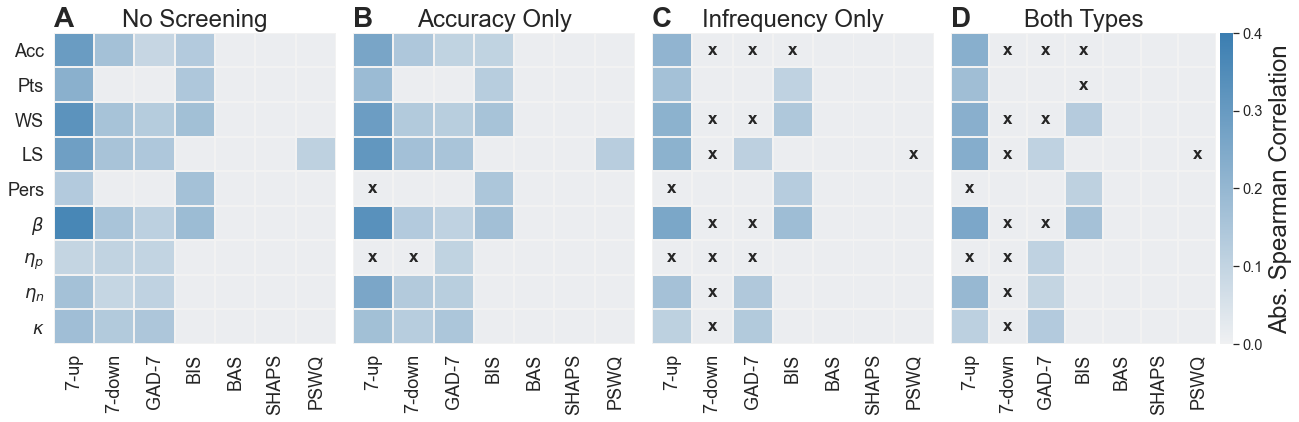

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define canvas.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(18,6))

## Initialize panels.
gs = gridspec.GridSpec(1,4)
gs.update(left=0.04, right=0.95, bottom=0.2, top=0.92, hspace=0, wspace=0.06)

## Define aesthetic features.
cmap = sns.light_palette('#3b7eb1', as_cmap=True)
label_pad = 6

## Define labels.
labels = ['A','B','C','D']
xticklabels = ['7-up', '7-down', 'GAD-7', 'BIS', 'BAS', 'SHAPS', 'PSWQ']
yticklabels = ['Acc', 'Pts', 'WS', 'LS', 'Pers', r'$\beta$', r'$\eta_p$', r'$\eta_n$', r'$\kappa$'] 
titles = ['No Screening', 'Accuracy Only', 'Infrequency Only', 'Both Types']

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for k in range(corr.shape[0]):
    
    ## Initialize axis.
    ax = plt.subplot(gs[k])
    
    ## Define colorbar parameters.
    if k == 3:
        cbar = True
        divider = make_axes_locatable(ax)
        cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
    else:
        cbar = False
        cbar_ax = None
    
    ## Plot correlations.
    sns.heatmap(np.zeros_like(corr[k]), cmap=ListedColormap(['#ebedf0']), cbar=False, ax=ax)    
    sns.heatmap(np.abs(corr[k]), vmin=0.0, vmax=0.40, linecolor='0.95', linewidths=1, 
                cmap=cmap,  mask=pval[k] > 0.05, cbar=cbar, ax=ax, cbar_ax=cbar_ax)
        
    ## Add title.
    ax.set_title(titles[k], fontsize=24)
    ax.text(0, 0, labels[k], ha='left', va='bottom', fontsize=28, fontweight='bold')
    
    ## Add ticklabels.
    ax.set_yticklabels([], rotation=0)
    ax.set_xticklabels(xticklabels, fontsize=18, rotation=90)
    if not k: ax.set_yticklabels(yticklabels, fontsize=18, rotation=0)
    
    ## Extract correlations.
    arr = np.where(corr[k] * (pval[k] < 0.05), 1, 0)
    if not k: template = arr.copy()
    
    ## Add markers.
    for i, j in np.array(np.where(np.logical_and(template, 1-arr))).T:
        ax.text(j+0.5, i+0.5, 'x', ha='center', va='center', fontsize=17, fontweight='bold')
        
    ## Update colorbar.
    if cbar:
        cbar = ax.collections[-1].colorbar
        cbar.set_ticks(np.linspace(0.0,0.4,5))
        cbar.set_label(r"Abs. Spearman Correlation", fontsize=24, labelpad=6)
        
## Save figure.
plt.savefig(os.path.join('figures','main_03a.png'), dpi=180, transparent=True)

#### 3.2 Supplementary Figure

/Users/szoro/Documents/software/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: FixedFormatter should only be used together with FixedLocator


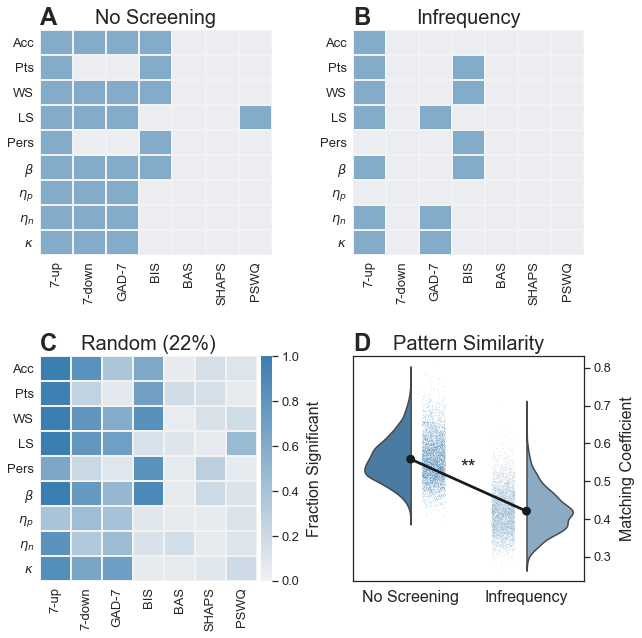

In [7]:
from pandas import DataFrame

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define canvas.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(9,9))

## Initialize panels.
gs = gridspec.GridSpec(2,2)
gs.update(left=0.06, right=0.9, bottom=0.1, top=0.95, hspace=0.45, wspace=0.35)

## Define labels.
xticklabels = ['7-up', '7-down', 'GAD-7', 'BIS', 'BAS', 'SHAPS', 'PSWQ']
yticklabels = ['Acc', 'Pts', 'WS', 'LS', 'Pers', r'$\beta$', r'$\eta_p$', r'$\eta_n$', r'$\kappa$'] 

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Re-plot correlations.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for i, (title, label) in enumerate(zip(['No Screening', 'Infrequency'], ['A','B'])):

    ## Initialize axis.
    ax = plt.subplot(gs[0,i])

    ## Plot correlations.
    sns.heatmap(pval[i*2]<0.05, cmap=ListedColormap(['#ebedf0','#83accb']),
                cbar=False, linecolor='0.95', linewidths=1,  ax=ax)

    ## Add title.
    ax.set_title(title, fontsize=20)
    ax.text(0, 0, label, ha='left', va='bottom', fontsize=24, fontweight='bold')

    ## Add ticklabels.
    ax.set_xticklabels(xticklabels, fontsize=13, rotation=90)
    ax.set_yticklabels(yticklabels, fontsize=13, rotation=0)
    ax.tick_params(axis='both', which='major', pad=0)
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot bootstrapping analysis.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
## Initialize axis.
ax = plt.subplot(gs[1,0])
divider = make_axes_locatable(ax)
cbar_ax = divider.append_axes("right", size="5%", pad=0.05)

## Plot correlations.
sns.heatmap(fpr, vmin=0, vmax=1, cmap=sns.light_palette('#3b7eb1', as_cmap=True), 
            cbar=True, linecolor='0.95', linewidths=1, ax=ax, cbar_ax=cbar_ax)

## Add title.
ax.set_title('Random (22%)', fontsize=20)
ax.text(0, 0, 'C', ha='left', va='bottom', fontsize=24, fontweight='bold')

## Add ticklabels.
ax.set_xticklabels(xticklabels, fontsize=13, rotation=90)
ax.set_yticklabels(yticklabels, fontsize=13, rotation=0)
ax.tick_params(axis='both', which='major', pad=0)

## Update colorbar.
cbar = ax.collections[-1].colorbar
cbar.ax.tick_params(labelsize=13)
cbar.set_label(r"Fraction Significant", fontsize=16, labelpad=8)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot simple matching correlations.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Initialize axis.
ax = plt.subplot(gs[1,1])
palette = ['#3b7eb1', '#83accb']

## Define DataFrame.
smc = DataFrame(dict(
    screening = np.repeat([0,1],smc_1.size),
    coef = np.concatenate([smc_1, smc_3]).copy(),
))

## Add jitter (for aesthetic purposes).
smc.coef += np.random.normal(0,1e-2,smc.coef.size)

## Plot simple matching correlations.
sns.violinplot(x='screening', y='coef', hue='screening', data=smc, palette=palette,
               cut=0, inner=None, split='True', zorder=-1)
sns.stripplot(x='screening', y='coef', hue=1-smc.screening, data=smc, palette=palette[::-1],
              dodge=True, jitter=0.20, size=0.5, alpha=0.9, zorder=-1)
sns.pointplot(x='screening', y='coef', data=smc, dodge=True, color='k')

## Add title.
ax.set_title('Pattern Similarity', fontsize=20)
ax.annotate('D', (0,0), (0,1), xycoords='axes fraction', ha='left', va='bottom', 
            fontsize=24, fontweight='bold')

## Add ticklabels.
ax.yaxis.tick_right(); ax.yaxis.set_label_position("right")
ax.set_xlabel(''); ax.set_ylabel('Matching Coefficient', fontsize=16, labelpad=8)
ax.set_xticklabels(['No Screening','Infrequency'], fontsize=16)
ax.set_yticklabels(np.arange(0.2,0.8,0.1).round(1), fontsize=13)
ax.legend_.set_visible(False)

## Add statistical test.
ax.annotate('**', (0,0), (0.5,0.5), xycoords='axes fraction', ha='center', va='center', fontsize=20)

## Save figure.
plt.savefig(os.path.join('figures','supp_01.png'), dpi=180, transparent=True)

#### 3.3 Supplementary Tables

In [8]:
from pandas import DataFrame

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define tables.
tables = ['No Screening', 'Accuracy Only', 'Infrequency Only', 'Both Types']

## Define columns.
columns = ['7u', '7d', 'GAD-7', 'BIS', 'BAS', 'SHAPS', 'PSWQ']
index = ['Acc', 'Pts', 'WS', 'LS', 'Pers', r'$\beta$', r'$\eta_p$', r'$\eta_n$', r'$\kappa$'] 

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for i, table in enumerate(tables):
    print(f'Constructing Table {i+1}: {table}.')

    ## Initialize table.
    fmt = lambda r, p: '%0.3f*' %r if p < 0.05 else '%0.3f' %r
    table = [fmt(r,p) for r, p in zip(corr[i].flatten(), pval[i].flatten())]
    table = np.array(table).reshape(corr[i].shape)
    
    ## Convert to DataFrame.
    table = DataFrame(table, index=index, columns=columns)

    ## Print LaTeX.
    print(table.to_latex())

Constructing Table 1: No Screening.
\begin{tabular}{llllllll}
\toprule
{} &       7u &       7d &    GAD-7 &      BIS &     BAS &   SHAPS &    PSWQ \\
\midrule
Acc      &  -0.295* &  -0.166* &  -0.093* &  -0.134* &  -0.020 &  -0.051 &  -0.037 \\
Pts      &  -0.225* &   -0.076 &   -0.023 &  -0.144* &  -0.061 &  -0.051 &   0.024 \\
WS       &  -0.327* &  -0.160* &  -0.129* &  -0.171* &  -0.006 &  -0.048 &  -0.062 \\
LS       &   0.285* &   0.158* &   0.146* &    0.050 &  -0.037 &   0.000 &  0.110* \\
Pers     &   0.134* &    0.066 &    0.032 &   0.166* &   0.018 &   0.080 &  -0.004 \\
\$\textbackslash beta\$  &  -0.370* &  -0.157* &  -0.114* &  -0.185* &   0.017 &  -0.063 &  -0.043 \\
\$\textbackslash eta\_p\$ &  -0.097* &  -0.105* &  -0.101* &   -0.033 &  -0.020 &  -0.015 &  -0.041 \\
\$\textbackslash eta\_n\$ &   0.168* &   0.094* &   0.108* &   -0.050 &  -0.056 &  -0.020 &   0.042 \\
\$\textbackslash kappa\$ &  -0.175* &  -0.137* &  -0.147* &   -0.008 &  -0.020 &  -0.028 &  -0.061 \\
